<center><h1> Conditional Graph Generative Model for Neural Architecture Search </h1></center>

<p><i><b>Goal</b>: In this notebook, we will explain the problem of Neural Architecture Search using the NAS-Bench-101 dataset.</i></p>

<h2>Introduction</h2>

<p><a href='https://www.jmlr.org/papers/volume20/18-598/18-598.pdf?ref=https://githubhelp.com'>Neural Architecture Search(NAS)</a> is the process of searching for neural network models
in an automated way. NAS is hard to perform due to the various combination of choices for neural
network architecture. For instance, the first layer of the neural network can be a convolution layer,
or Dense layer, or an Embedding layer, etc. This first layer can be connected to the next layer as
well to any other subsequent layers. Since there are no restrictions on the number of layers and their
connectivity, there are many possible neural network architectures.</p>

<h3>Dataset Analysis</h3>

<p><a href='https://arxiv.org/abs/1902.09635'>NAS-101</a> Benchmark dataset provides 423624 unique models. Each model trained for epochs 4, 12,
36, and 108. The model performance included in the dataset is training accuracy, validation accuracy,
testing accuracy, number of parameters, and training time. We will use the NAS-101 benchmarks to
create a new dataset.</p>

<p>We will now use the nas-101 benchmarks to create a new dataset.</p>

<ul>
    <li>Only benchmarks with 108 epochs</li>
    <li>Only include architectures with test accuracy greater than 80 percent accuracy.  The intention is
to learn high-performing architecture to generate networks with similar characteristics.</li>
    <li>Restrict the number of architectures to maximum of 1000</li>
</ul>

<p>We will select features in the dataset like adjacency matrices, layer names as part of training. We
will perform sanity checks related to the graph structure and neural network architecture.</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/google-research/nasbench
!pip install ./nasbench

Cloning into 'nasbench'...
remote: Enumerating objects: 96, done.
remote: Total 96 (delta 0), reused 0 (delta 0), pack-reused 96
Unpacking objects: 100% (96/96), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./nasbench
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for nasbench: filename=nasbench-1.0-py3-none-any.whl size=46788 sha256=9ace01a00a7fda21772b86b0f3928461368ab95a9001f91a639acb0b3c6cfa51
  Stored in directory: /tmp/pip-ephem-wheel-cache-g0a1173l/wheels/64/e0/f5/7eabfceccbb11fce1ab5888a8d31f59fcb43f2b5cfc53ba6d7
Successfully built nasbench


In [ ]:
import base64
from nasbench.lib import model_metrics_pb2
import tensorflow as tf
import networkx as nx
import os
import json
import numpy as np
tf.compat.v1.enable_eager_execution()

In [ ]:
!curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  498M  100  498M    0     0  54.5M      0  0:00:09  0:00:09 --:--:-- 65.3M


In [ ]:
import os
os.path.curdir

'.'

In [ ]:
#download the dataset https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord
#include the downloaded file path in data_dir
#data_dir = '/content/drive/MyDrive/GRAN-NEW/GRAN-NAS-Pipeline/data/NAS-101'
data_dir = os.path.curdir
nas_101_filepath = os.path.join(data_dir, 'nasbench_only108.tfrecord')
nas_101_hp_filepath = os.path.join(data_dir, 'nasbench_1000_80_7.tfrecord')

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
graphs = list()

In [ ]:
#first time users please uncomment the below code to create the dataset from scratch.
count = 0
dataset = tf.compat.v1.python_io.tf_record_iterator(nas_101_filepath)
maxlength = 1000
with tf.io.TFRecordWriter(nas_101_hp_filepath) as writer:
  for serialized_row in dataset:
      module_hash, epochs, raw_adjacency, raw_operations, raw_metrics = json.loads(serialized_row.decode('utf-8'))
      metrics = model_metrics_pb2.ModelMetrics.FromString(base64.b64decode(raw_metrics))
      if metrics.evaluation_data[2].test_accuracy > 0.80:
          writer.write(serialized_row)
          dim = int(np.sqrt(len(raw_adjacency)))
          adjacency = np.array([int(e) for e in list(raw_adjacency)], dtype=np.int8)
          adjacency = np.reshape(adjacency, (dim, dim))
          graph = csr_matrix(adjacency)
          graphs.append(nx.Graph(graph))
          count += 1
          if count > maxlength:
              break

<p>Now, we have the dataset 'nasbench_hp.tfrecord'. We're ready to explore the dataset.</p>

<h3>NAS-101 benchmark details.</h3>

<p>Deep neural network architecture is represented as a directed acyclic graph in the dataset as shown below.</p>

<p>Let us look in detail at a single data point from the datasets.</p>

In [ ]:
dataset = tf.compat.v1.python_io.tf_record_iterator(nas_101_hp_filepath)
for serialized_row in dataset:
    module_hash, epochs, raw_adjacency, raw_operations, raw_metrics = json.loads(serialized_row.decode('utf-8'))
    dim = int(np.sqrt(len(raw_adjacency)))
    adjacency = np.array([int(e) for e in list(raw_adjacency)], dtype=np.int8)
    adjacency = np.reshape(adjacency, (dim, dim))
    operations = raw_operations.split(',')
    metrics = model_metrics_pb2.ModelMetrics.FromString(
      base64.b64decode(raw_metrics))
    graph = nx.Graph(adjacency)
    break

In [ ]:
print("The number of layers in the network are ", dim)

The number of layers in the network are  7


In [ ]:
print("The sequence of operations are ")
operations

The sequence of operations are 


['input',
 'conv3x3-bn-relu',
 'maxpool3x3',
 'conv3x3-bn-relu',
 'conv3x3-bn-relu',
 'conv1x1-bn-relu',
 'output']

<p>The evaluation metrics contain details of the neural network at the beginning, halfway through, and at epoch 108.  At each stage of training, the benchmark dataset contains the below details:</p>

<ul>
    <li>Epoch number</li>
    <li>Training time</li>
    <li>Training accuracy</li>
    <li>Validation accuracy</li>
    <li>Test accuracy</li>
</ul>

In [ ]:
print("Evaluation data at the begining of the training")
metrics.evaluation_data[0]

Evaluation data at the begining of the training


current_epoch: 0.0
training_time: 0.0
train_accuracy: 0.10166265815496445
validation_accuracy: 0.10176282376050949
test_accuracy: 0.09985977411270142

In [ ]:
print("Evaluation data halfway through the training")
metrics.evaluation_data[1]

Evaluation data halfway through the training


current_epoch: 54.0
training_time: 883.4580078125
train_accuracy: 0.8282251358032227
validation_accuracy: 0.7776442170143127
test_accuracy: 0.7740384340286255

In [ ]:
print("Evaluation data at epoch 108 of the training")
metrics.evaluation_data[2]

Evaluation data at epoch 108 of the training


current_epoch: 108.0
training_time: 1769.1279296875
train_accuracy: 1.0
validation_accuracy: 0.9241786599159241
test_accuracy: 0.9211738705635071

<h3>General graph properties</h3>

<p>We will now look at this data in terms of directed acyclic graph</p>

In [ ]:
print("Number of nodes in the graph")
graph.number_of_nodes()

Number of nodes in the graph


7

In [ ]:
print("Number of edges in the graph")
graph.number_of_edges()

Number of edges in the graph


9

In [ ]:
print("There should not be isolated nodes in an architecture.")
print("Number of connected components in the graph.")
list(nx.connected_components(graph))

There should not be isolated nodes in an architecture.
Number of connected components in the graph.


[{0, 1, 2, 3, 4, 5, 6}]

<p>We need to add labels to the graph before we can clearly visualize the neural network architecture</p>

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
labels = {i: operations[i] for i in range(dim)}
labels

{0: 'input',
 1: 'conv3x3-bn-relu',
 2: 'maxpool3x3',
 3: 'conv3x3-bn-relu',
 4: 'conv3x3-bn-relu',
 5: 'conv1x1-bn-relu',
 6: 'output'}

In [ ]:
edge_list = list(graph.edges)

{0: Text(-1.0, -8.742277657347586e-08, 'input'),
 1: Text(-0.6234896183013916, -0.7818316221237183, 'conv3x3-bn-relu'),
 2: Text(0.9009689092636108, 0.4338836371898651, 'maxpool3x3'),
 3: Text(0.22252069413661957, 0.9749279618263245, 'conv3x3-bn-relu'),
 4: Text(0.22252103686332703, -0.9749279022216797, 'conv3x3-bn-relu'),
 5: Text(0.9009688496589661, -0.43388375639915466, 'conv1x1-bn-relu'),
 6: Text(-0.6234895586967468, 0.781831681728363, 'output')}

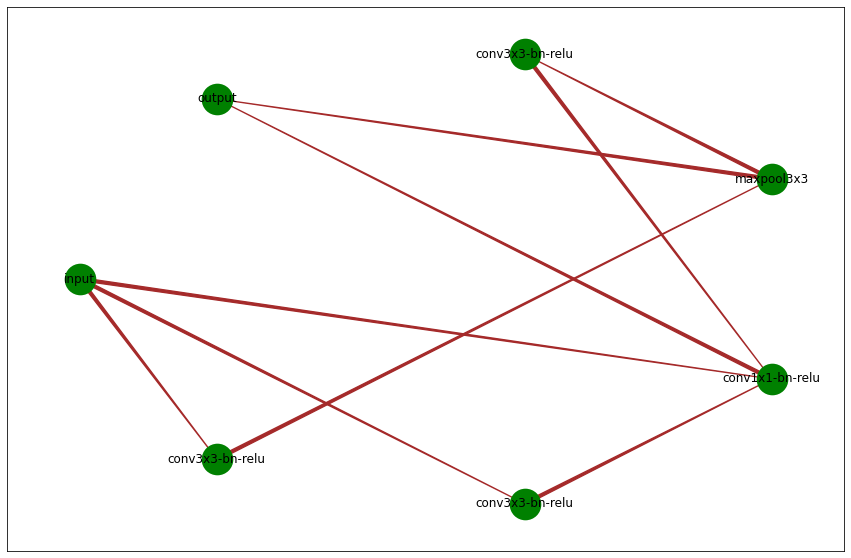

In [ ]:
graph = nx.DiGraph()
graph.add_edges_from(edge_list)
pos = nx.shell_layout(graph)
plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(
          graph,
          pos,
          node_size=1000,
          node_color='green',
          alpha=1,
          linewidths=0)
nx.draw_networkx_edges(graph, pos, alpha=1, width=1.3, edge_color="brown", arrows=True, arrowsize=10, arrowstyle='wedge')
nx.draw_networkx_labels(graph, pos, labels=labels, 
                        font_size=12, font_family='sans-serif')

<p>The visualization from Networkx lacks the structure of the data flow in the neural network architecture.  So, we now visualize with another tool called <a href="https://pypi.org/project/pydot/">pydot</a>.  This library implements the general graph visualization language from <a href="https://www.graphviz.org/">Graphviz</a></p>

In [ ]:
import networkx as nx
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import StringIO
from IPython.display import SVG
import pydot

<p>The visualization proceduce is adapted from kaggle tutorial: <a href="https://www.kaggle.com/kmader/flowcharts-pydot">Flowcharts PyDot</a></p>

In [ ]:
dot_graph = pydot.Dot(graph_type='digraph')

In [ ]:
def make_node(name):
    cur_node = pydot.Node(name)
    cur_node.set_shape('box')
    dot_graph.add_node(cur_node)
    return cur_node

In [ ]:
def make_link(a_node, b_node, label = None, width = 1, style='vee'):
    cur_edge = pydot.Edge(a_node,b_node)
    cur_edge.set_penwidth(width)
    cur_edge.set_style(style)
    if label is not None: cur_edge.set_label(label)
    dot_graph.add_edge(cur_edge)
    return cur_edge

In [ ]:
nodes = dict()
for i in range(dim):
    nodes[i] = make_node(f"Layer {i} {labels[i]}")

In [ ]:
edges = dict()
for edge in edge_list:
    make_link(nodes[edge[0]], nodes[edge[1]])

In [ ]:
viz_dir = 'graphviz'
architecture_filepath = os.path.join(viz_dir, 'architecture.svg')

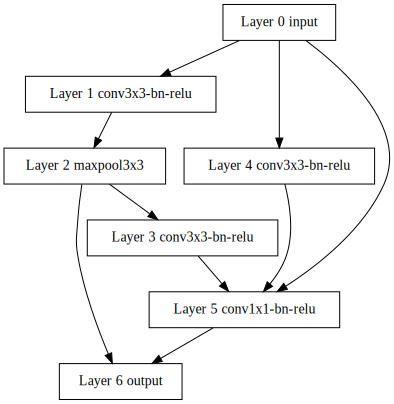

In [ ]:
dot_graph.write_svg(architecture_filepath, prog = 'dot')
SVG(architecture_filepath)

<h3>Dataset Analysis</h3>

<p>We are ready to begin analysis on the dataset used for training and evaluation of the model.</p>

<p>Initially, we will be using only the graph adjacency and layer types for the training and evaluation. We will collect all the details from the NAS-101 benchmark except for the module_hash.</p>

In [ ]:
graphs_nas=list()
dataset = tf.compat.v1.python_io.tf_record_iterator(nas_101_hp_filepath)
index = 0
operations = {'input':0, 'conv3x3-bn-relu':1, 'conv1x1-bn-relu':2, 'maxpool3x3':3, 'output':4}
for serialized_row in dataset:
    module_hash, epochs, raw_adjacency, raw_operations, raw_metrics = json.loads(serialized_row.decode('utf-8'))
    dim = int(np.sqrt(len(raw_adjacency)))
    adjacency = np.array([int(e) for e in list(raw_adjacency)], dtype=np.int8)
    adjacency = np.reshape(adjacency, (dim, dim))
    graph_ops = raw_operations.split(',')
    metrics = model_metrics_pb2.ModelMetrics.FromString(
      base64.b64decode(raw_metrics))
    graph = nx.Graph(csr_matrix(adjacency))
    graph_ops = raw_operations.split(',')
    for node_idx in range(graph.number_of_nodes()):
        graph.add_node(node_idx, label=operations[graph_ops[node_idx]])
    nasitem = [index, graph, graph_ops, metrics.evaluation_data[2]]
    graphs_nas.append(nasitem)
    index += 1

In [ ]:
for nas_item in graphs_nas:
    print(nas_item[1].nodes.data())
    print([node['label'] for idx, node in nas_item[1].nodes.data()])
    print(np.array([node['label'] for idx, node in nas_item[1].nodes.data()]).astype(np.uint8))
    print(nas_item[2])
    break

[(0, {'label': 0}), (1, {'label': 1}), (2, {'label': 3}), (3, {'label': 1}), (4, {'label': 1}), (5, {'label': 2}), (6, {'label': 4})]
[0, 1, 3, 1, 1, 2, 4]
[0 1 3 1 1 2 4]
['input', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'output']


<p>We will split the training and validation into 80% and 20% of the total graphs. The remaining data will serve as the test dataset.</p>

In [ ]:
seed = 1234
train_ratio = 0.8
dev_ratio = 0.2

In [ ]:
num_graphs = len(graphs_nas)
num_train = int(float(num_graphs) * train_ratio)
num_dev = int(float(num_graphs) * dev_ratio)
num_test_gt = num_graphs - num_train

In [ ]:
npr = np.random.RandomState(seed)
npr.shuffle(graphs_nas)

In [ ]:
num_train = int(float(num_graphs) * train_ratio)
num_dev = int(float(num_graphs) * dev_ratio)
num_test_gt = num_graphs - num_train

In [ ]:
graphs_ds = [graph for index, graph, operations, evaluation_data in graphs_nas]

In [ ]:
graphs_train = graphs_ds[:num_train]
graphs_dev = graphs_ds[:num_dev]
graphs_test = graphs_ds[num_train:]

<p>Before we begin the training, let us closely look at the performance statistics of the architectures in the train, dev, and test datasets.</p>

In [ ]:
training_ds_perf_stats = [evaluation_data for index, graph, operations, evaluation_data in graphs_nas[:num_train]]
dev_ds_perf_stats = [evaluation_data for index, graph, operations, evaluation_data in graphs_nas[:num_dev]]
test_ds_perf_stats = [evaluation_data for index, graph, operations, evaluation_data in graphs_nas[num_train:]]

In [ ]:
training_ds_architecture_training_time = [evaluation_data.training_time for evaluation_data in training_ds_perf_stats]
dev_ds_architecture_training_time = [evaluation_data.training_time for evaluation_data in dev_ds_perf_stats]
test_ds_architecture_training_time = [evaluation_data.training_time for evaluation_data in test_ds_perf_stats]

955
238
239


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


{'boxes': [<matplotlib.lines.Line2D at 0x7f1da8ef9190>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1da8eff210>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1da8f05250>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1da8effcd0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f1da8ef9750>,
  <matplotlib.lines.Line2D at 0x7f1da8f20790>]}

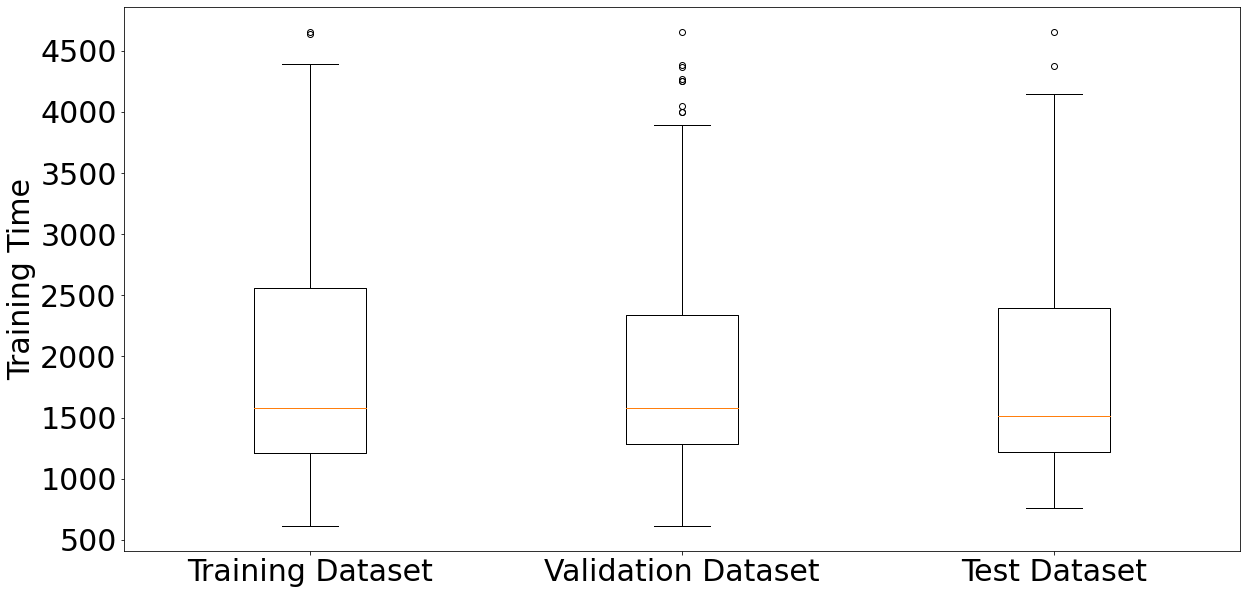

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["axes.titlesize"] = 30
plt.rcParams["figure.titlesize"] = 30
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams["legend.fontsize"] = 30
#plt.rcParams["legend.loc"] = 'upper left'
plt.rcParams["legend.loc"] = 'best'
plt.ylabel('Training Time')
plt.boxplot([training_ds_architecture_training_time, dev_ds_architecture_training_time, test_ds_architecture_training_time], labels=['Training Dataset', 'Validation Dataset', 'Test Dataset'])

In [ ]:
training_ds_architecture_training_accuracy = [evaluation_data.train_accuracy for evaluation_data in training_ds_perf_stats]
dev_ds_architecture_training_accuracy = [evaluation_data.train_accuracy for evaluation_data in dev_ds_perf_stats]
test_ds_architecture_training_accuracy = [evaluation_data.train_accuracy for evaluation_data in test_ds_perf_stats]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fde4e058280>,
 'caps': [<matplotlib.lines.Line2D at 0x7fde4e0589a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fde4e04beb0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fde4e063100>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fde4e063490>,
 'means': []}

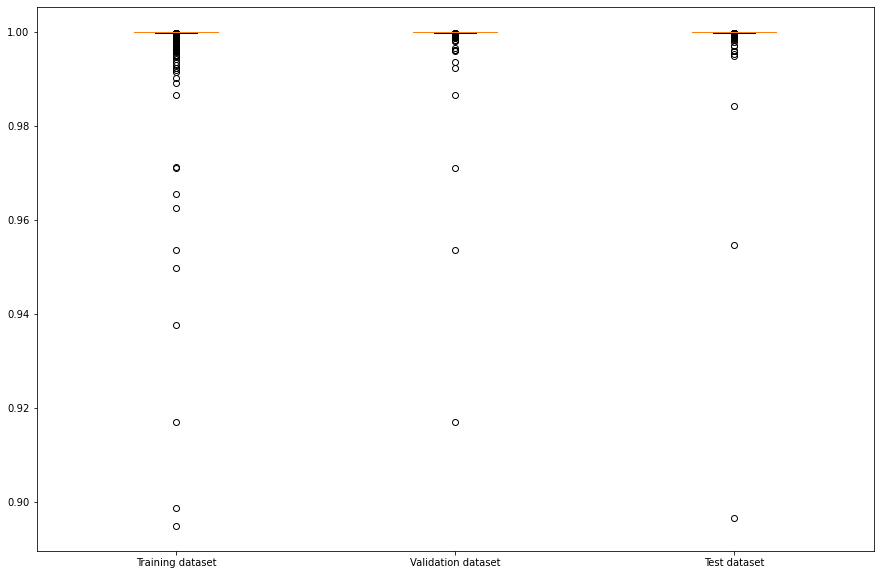

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,10))
plt.boxplot([training_ds_architecture_training_accuracy, dev_ds_architecture_training_accuracy, test_ds_architecture_training_accuracy],
           labels=['Training dataset', 'Validation dataset', 'Test dataset'])

In [ ]:
training_ds_architecture_validation_accuracy = [evaluation_data.validation_accuracy for evaluation_data in training_ds_perf_stats]
dev_ds_architecture_validation_accuracy = [evaluation_data.validation_accuracy for evaluation_data in dev_ds_perf_stats]
test_ds_architecture_validation_accuracy = [evaluation_data.validation_accuracy for evaluation_data in test_ds_perf_stats]

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


{'boxes': [<matplotlib.lines.Line2D at 0x7f1da8d7ea50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1da8d82ad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1da8d89b10>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1da8d895d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f1da8d82050>,
  <matplotlib.lines.Line2D at 0x7f1da8dac090>]}

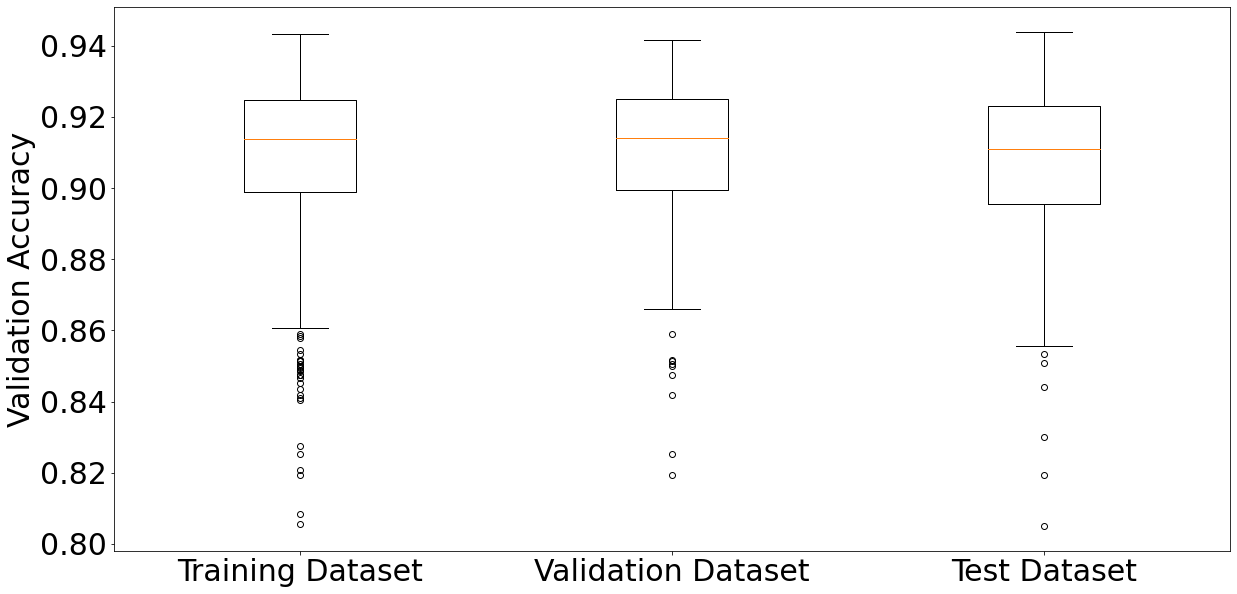

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["axes.titlesize"] = 30
plt.rcParams["figure.titlesize"] = 30
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams["legend.fontsize"] = 30
#plt.rcParams["legend.loc"] = 'upper left'
plt.rcParams["legend.loc"] = 'best'
plt.ylabel('Validation Accuracy')
plt.boxplot([training_ds_architecture_validation_accuracy, dev_ds_architecture_validation_accuracy, test_ds_architecture_validation_accuracy], labels=['Training Dataset', 'Validation Dataset', 'Test Dataset'])

In [ ]:
training_ds_architecture_test_accuracy = [evaluation_data.test_accuracy for evaluation_data in training_ds_perf_stats]
dev_ds_architecture_test_accuracy = [evaluation_data.test_accuracy for evaluation_data in dev_ds_perf_stats]
test_ds_architecture_test_accuracy = [evaluation_data.test_accuracy for evaluation_data in test_ds_perf_stats]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fde4df0aa90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fde4df171f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fde4df0a700>,
 'medians': [<matplotlib.lines.Line2D at 0x7fde4df17940>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fde4df17cd0>,
 'means': []}

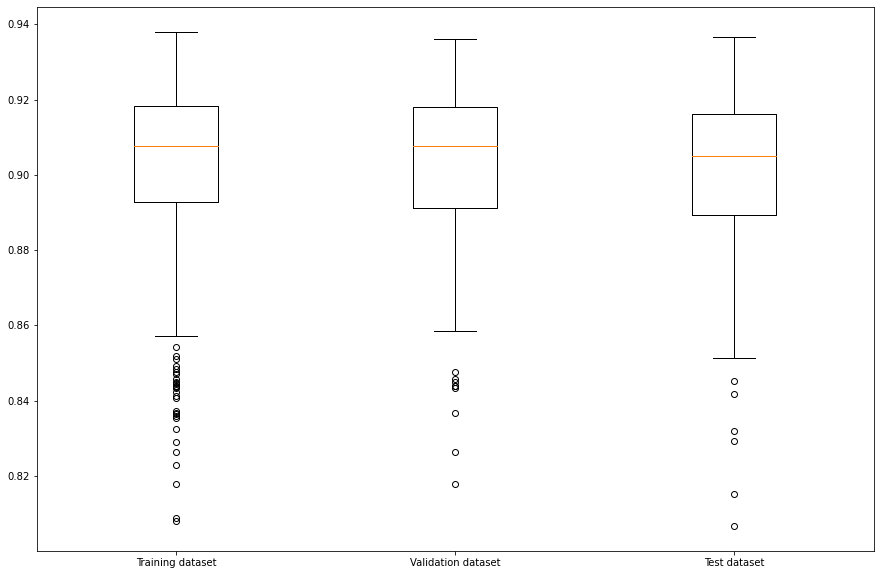

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,10))
plt.boxplot([training_ds_architecture_test_accuracy, dev_ds_architecture_test_accuracy, test_ds_architecture_test_accuracy],
           labels=['Training dataset', 'Validation dataset', 'Test dataset'])

<h3>Layer distribution analysis</h3>

<p>Let us know about the distribution of various layers in the dataset. The layer-wise distribution will allow us to determine the impact of imbalanced features set in the training, validation, and testing datasets.</p>

In [ ]:
training_ds_operations = [operations for index, graph, operations, evaluation_data in graphs_nas[:num_train]]
dev_ds_operations = [operations for index, graph, operations, evaluation_data in graphs_nas[:num_dev]]
test_ds_operations = [operations for index, graph, operations, evaluation_data in graphs_nas[num_train:]]

In [ ]:
training_ds_operations_freq = dict()
for operations in training_ds_operations:
    for layer in operations:
        if layer in training_ds_operations_freq.keys():
            training_ds_operations_freq[layer] +=1
        else:
            training_ds_operations_freq[layer] = 1
training_freq = [val/sum(training_ds_operations_freq.values()) for val in training_ds_operations_freq.values()]
training_freq

[0.1463377260190009,
 0.24655225252834814,
 0.22724486668709776,
 0.1463377260190009,
 0.23352742874655225]

In [ ]:
dev_ds_operations_freq = dict()
for operations in dev_ds_operations:
    for layer in operations:
        if layer in dev_ds_operations_freq.keys():
            dev_ds_operations_freq[layer] +=1
        else:
            dev_ds_operations_freq[layer] = 1
dev_freq = [val/sum(dev_ds_operations_freq.values()) for val in dev_ds_operations_freq.values()]
dev_freq

[0.14655172413793102,
 0.2512315270935961,
 0.2210591133004926,
 0.14655172413793102,
 0.23460591133004927]

In [ ]:
test_ds_operations_freq = dict()
for operations in test_ds_operations:
    for layer in operations:
        if layer in test_ds_operations_freq.keys():
            test_ds_operations_freq[layer] +=1
        else:
            test_ds_operations_freq[layer] = 1
test_freq = [val/sum(test_ds_operations_freq.values()) for val in test_ds_operations_freq.values()]
test_freq

[0.14671577655003068,
 0.24923265807243708,
 0.23756906077348067,
 0.14671577655003068,
 0.21976672805402087]

<Figure size 1440x720 with 0 Axes>

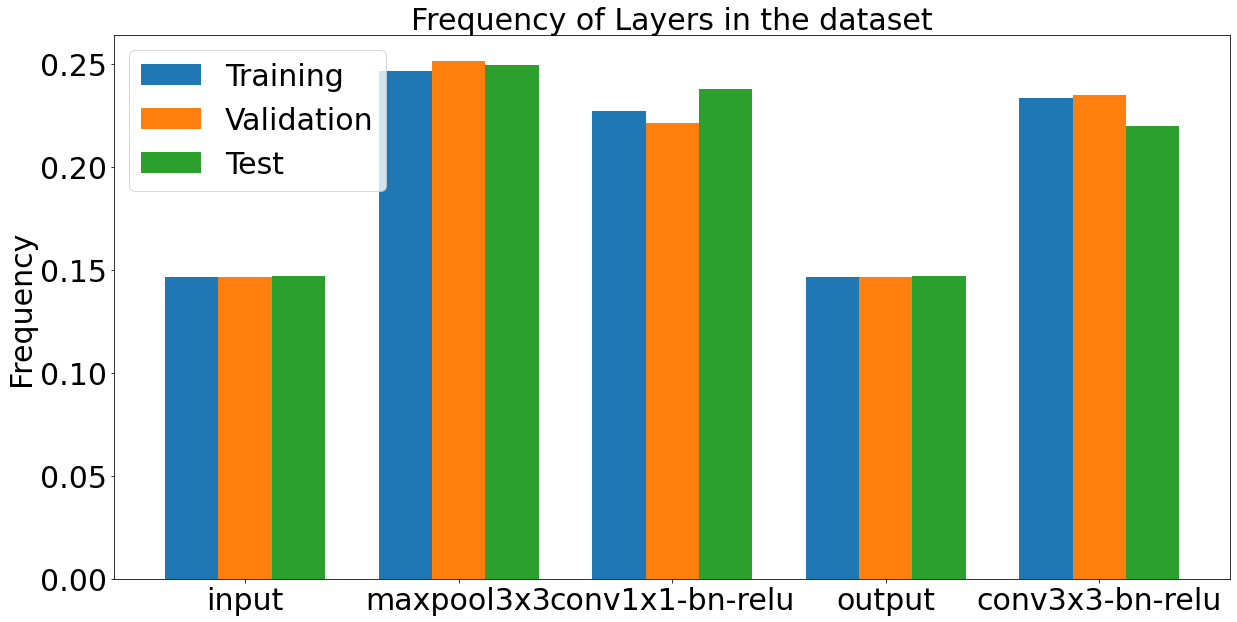

In [ ]:
operations = training_ds_operations_freq.keys()

x = np.arange(len(operations))  # the label locations
width = 0.25  # the width of the bars

plt.figure(figsize=(20,10))
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["axes.titlesize"] = 30
plt.rcParams["figure.titlesize"] = 30
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams["legend.fontsize"] = 30
#plt.rcParams["legend.loc"] = 'upper left'
plt.rcParams["legend.loc"] = 'best'
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, training_freq, width, label='Training')
rects2 = ax.bar(x, dev_freq, width, label='Validation')
rects3 = ax.bar(x + width, test_freq, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Layers in the dataset')
ax.set_xticks(x)
ax.set_xticklabels(operations)
ax.legend()

#
# fig.tight_layout()

plt.show()

<h3>Graph structure validation</h3>

<p>The NAS-101 represents the neural network architectures as directed acyclic graphs.  Though this dataset has been used extensively in research. We now carry out the below graph validations as sanity checks.  Later we'll perform the same validation check on the graphs generated using the GRAN model.</p>

<ul>
    <li>Self loops</li>
    <li>Isolate nodes</li>
    <li>Graph is directed or undirected</li>
<ul>

<h4>Self loops</h4>

<p>A self-loop check determines if the node connects to itself. For neural architecture, we don't expect the layers to connect to themselves. We will count the graphs which have self-loops.</p>

In [ ]:
num_graphs_with_self_loops = 0
for _, graph, _, _ in graphs_nas:
    num_graphs_with_self_loops += 1 if nx.number_of_selfloops(graph) > 0 else 0
print("Number of graphs with self loops ", num_graphs_with_self_loops)

Number of graphs with self loops  0


<h3>Isolated nodes</h3>

<p>Isolated nodes check will identify nodes not connected to any other in the graph.  In a neural network, we expect the layers to form connections with another layer. We will count the graphs with isolated nodes.<p>

In [ ]:
num_graphs_with_isolates = 0
for _, graph, _, _ in graphs_nas:
    num_graphs_with_isolates += 1 if nx.number_of_isolates(graph) > 0 else 0
print("Number of graphs with isolated nodes ", num_graphs_with_isolates)

Number of graphs with isolated nodes  0


<h3>Evaluation of the GRAN generated neural network architecture graphs</h3>

<p>One can evaluate the graph generation process using several metrics.  We consider the reconstruction accuracy of neural network architectures, validity, uniqueness, and novelty. We will look at each metric in detail in the coming sections.</p>

In [ ]:
# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench(nas_101_filepath)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
non-resource variables are not supported in the long term
Loaded dataset in 52 seconds


</p>Let us query the dataset using a simple example.</p>

In [ ]:
# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'

# GRAN output adjacecy matrix and label is used as input to the api
cell = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

# Querying multiple times may yield different results. Each cell is evaluated 3
# times at each epoch budget and querying will sample one randomly.
data = nasbench.query(cell)
for k, v in data.items():
  print('%s: %s' % (k, str(v)))

module_adjacency: [[0 1 1 1 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
module_operations: ['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
trainable_parameters: 2694282
training_time: 1157.675048828125
train_accuracy: 1.0
validation_accuracy: 0.9378004670143127
test_accuracy: 0.932692289352417


<p>We require the adjacency matrix and the corresponding node label (layer name) to query the NAS-101 benchmark dataset. Let us now check a failure case.</p>

In [ ]:
# #the below adjacency matrix has a selfloop in the input node
# cell = api.ModelSpec(
#   matrix=[[1, 1, 1, 1, 0, 1, 0],    # input layer
#           [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
#           [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
#           [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
#           [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
#           [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
#           [0, 0, 0, 0, 0, 0, 0]],   # output layer
#   # Operations at the vertices of the module, matches order of matrix.
#   ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

# # Querying multiple times may yield different results. Each cell is evaluated 3
# # times at each epoch budget and querying will sample one randomly.
# data = nasbench.query(cell)
# for k, v in data.items():
#   print('%s: %s' % (k, str(v)))

<p>The NAS-101 benchmark errors are not helpful but, it rejects samples not valid in the dataset. Thus, we have enough information to validate the graphs generated from the GRAN model.</p>

<h3>Validity</h3>

</p>Validity measures the number of validly generated graphs. Specifically, it has to satisfy the constraints of Directed Acyclic Graph and Neural Networks.</p>

<ul>
    <li>Only the input node is at the start.</li>
    <li>Only the output node is at the end.</li>
    <li>Except for the output node, there should not be any node without a successor.</li>
    <li>Except for the input node, there should not be any node without a predecessor.</li>
</ul>

<p>Fortunately, the NAS-101 benchmark API also provides a method to validate the generated graph. Like the previous test, we need to pass the adjacency matrix and its corresponding node label. The API will provide the validated result.</p>

In [ ]:
# GRAN output adjacecy matrix and label is used as input to the api
cell = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

print("Is the generated graph valid? ", nasbench.is_valid(cell))

Is the generated graph valid?  True


<p>Let us now test a failure case as usual.</p>

In [ ]:
# GRAN output adjacecy matrix and label is used as input to the api
cell = api.ModelSpec(
  matrix=[[0, 1, 0, 0, 0, 0, 0],    # input layer
          [0, 0, 1, 0, 1, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 1, 0, 1, 0],    # 3x3 max-pool
          [0, 0, 0, 0, 1, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 1, 0],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, MAXPOOL3X3, MAXPOOL3X3, MAXPOOL3X3, MAXPOOL3X3, MAXPOOL3X3, OUTPUT])

print("Is the generated graph valid? ", nasbench.is_valid(cell))

Is the generated graph valid?  False


<p>Let us look at few more failure example.</p>

In [ ]:
# GRAN output adjacecy matrix and label is used as input to the api
cell = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[MAXPOOL3X3, INPUT, MAXPOOL3X3, MAXPOOL3X3, MAXPOOL3X3, MAXPOOL3X3, OUTPUT])

print("Is the generated graph valid? ", nasbench.is_valid(cell))

Is the generated graph valid?  False


In [ ]:
# GRAN output adjacecy matrix and label is used as input to the api
cell = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, MAXPOOL3X3, MAXPOOL3X3, MAXPOOL3X3, MAXPOOL3X3, OUTPUT, MAXPOOL3X3])

print("Is the generated graph valid? ", nasbench.is_valid(cell))

Is the generated graph valid?  False


<h3>Uniqueness</h3>

<p>Uniqueness measures the unique share of the generated graphs. Simply put, we calculate the graph similarity.  If the generated graphs are diverse among the generated graphs, then the generative model produces unique graphs.</p>

<p>We will randomly pick ten graphs from our sample NAS dataset. Then we will use the networkx library for measuring graph similarity.</p>

In [ ]:
random_indexes = np.random.randint(0, len(graphs_nas), (10), dtype=np.int64)
random_indexes

array([1166,  358,   66,  279,  703,  196,  925,  568,  872,  596])

In [ ]:
sampled_graphs = list()
for index in range(len(random_indexes)):
    sampled_graphs.append(graphs_nas[index][1])
len(sampled_graphs)

10

<p>Graph edit distance measure tells us the minimum of edits in nodes and edges required in a graph to produce a corresponding isomorphic graph.</p>

<p>For our purpose, we will use a fast graph edit distance algorithm available in networkx. We will sum up the graph edit distance of all the generated graphs.  The higher the value of the sum of the graph edit distance, the more diverse the graphs in the sampled_graphs.</p>

In [ ]:
sum_minimum_graph_edit_distance = list()
for i in range(10):
    for j in range(i+1, 9):
        sum_minimum_graph_edit_distance.append(int(min(nx.optimize_graph_edit_distance(sampled_graphs[i], sampled_graphs[j]))))

<p>Let us display the mean, variation, and standard deviation of graph edit distance.</p>

In [ ]:
print("Mean graph edit distance", np.mean(sum_minimum_graph_edit_distance))
print("Variations of the graph edit distance", np.var(sum_minimum_graph_edit_distance))
print("Standard deviation of the graph edit distance", np.std(sum_minimum_graph_edit_distance))

Mean graph edit distance 3.111111111111111
Variations of the graph edit distance 1.6543209876543215
Standard deviation of the graph edit distance 1.2862041003100253


<p>If the value of the minimum graph edit distance between two graphs is zero, then we have created the same graph. Now, let us check if there is zero edit distance in the sampled graphs.</p>

In [ ]:
print("Does any of the graphs generated are the same? ",  min(sum_minimum_graph_edit_distance)== 0)

Does any of the graphs generated are the same?  True


<p>As it turns out, we have an isomorphic graph in the sampled graphs. The frequency of the minimum graph edit distance will give us more information.</p>

In [ ]:
freq_distribution = dict()
for item in sum_minimum_graph_edit_distance:
    if item in freq_distribution.keys():
        freq_distribution[item] += 1
    else:
        freq_distribution[item] = 1
freq_distribution

{2: 16, 5: 6, 4: 11, 0: 1, 3: 2}

<p>We will now look at the distribution of the sum_minimum_graph_edit_distance.</p>

In [ ]:
total_min_graph_edit_distance = sum(freq_distribution.values())
normalized_freq_distribution = dict()
for key in freq_distribution:
    normalized_freq_distribution[key] = freq_distribution[key]/total_min_graph_edit_distance*100
normalized_freq_distribution

{2: 44.44444444444444,
 5: 16.666666666666664,
 4: 30.555555555555557,
 0: 2.7777777777777777,
 3: 5.555555555555555}

<p>The above distribution clearly shows that greater than 75% of the graphs require a minimum of three edits in nodes or edges to create a corresponding isomorphic graph. The results indicate a diverse set of graphs.</p>

<h3>Novelty</h3>

<p>We measure novelty as the number of validly generated graphs not available in the training dataset. We believe there are many ways to measure novelty by describing node, edge, or graph properties. Here, we consider two types of measurement for describing novelty metrics.</p>

<ul>
    <li>Graph isomorphism test</li>
    <li>Graph edit distance similarity</li>
<ul>

<h3>Graph isomorphism test</h3>

<p>Here we will just measure the number of generated graphs that are isomorphic to the training dataset.</p>

<p>We will create a randomly picked training set.  This training set will be utilized to evaluate the effectiveness of the novelty tests.</p>

In [ ]:
random_indexes = np.random.randint(0, len(graphs_nas), (10), dtype=np.int64)
training_graphs = list()
for index in range(len(random_indexes)):
    training_graphs.append(graphs_nas[index][1])
len(training_graphs)

10

<p>Here we will compare each graph from the training set with each graph from the generated graphs. This process is not scalable to a large number of graphs. For large dataset comparison, please consider methods like clustered membership of generated graph with the training graphs. Therefore, the clustering approach will significantly reduce the computational workload.
</p>

In [ ]:
num_isomorphic_graphs = 0
for train_index in range(10):
    for gen_index in range(10):
        if nx.is_isomorphic(training_graphs[train_index], sampled_graphs[gen_index]):
            num_isomorphic_graphs += 1
            break
print("Total number of graphs similar to the training set are ", num_isomorphic_graphs)

Total number of graphs similar to the training set are  10


<p>The results indicate there is at least one graph is similar to the graphs in the training set.</p>


<h3>Graph edit distance measure</h3>

<p>As defined earlier, graph edit distance measure the number of changes required to make one graph isomorphic to another graph. The graph edit distance metric will measure the novelty as the number of changes in the generated graphs to create the same graph in the training set. Therefore, the more the graph edit distance, the more the novelty of the graph generation model.</p>

In [ ]:
sum_minimum_graph_edit_distance = list()
for i in range(10):
    for j in range(10):
        sum_minimum_graph_edit_distance.append(int(min(nx.optimize_graph_edit_distance(training_graphs[i], sampled_graphs[j]))))

In [ ]:
freq_distribution = dict()
for item in sum_minimum_graph_edit_distance:
    if item in freq_distribution.keys():
        freq_distribution[item] += 1
    else:
        freq_distribution[item] = 1
freq_distribution

{0: 12, 2: 42, 5: 14, 4: 28, 3: 4}

<p>We do the same analysis between the generated graphs and the training graphs.</p>

In [ ]:
total_min_graph_edit_distance = sum(freq_distribution.values())
normalized_freq_distribution = dict()
for key in freq_distribution:
    normalized_freq_distribution[key] = freq_distribution[key]/total_min_graph_edit_distance*100
normalized_freq_distribution

{0: 12.0, 2: 42.0, 5: 14.000000000000002, 4: 28.000000000000004, 3: 4.0}

<p>80% generated graphs require an edit of at least 3 in the nodes or the edges to create a corresponding isomorphic graph in the training set. We can observe that our GRAN generative model discovers novel neural network architecture.</p>